# Dataset Trentino
Registrazione delle misure recuperate dal database X.

La procedura si articola nei seguenti passaggi:
1. [caricamento dei dati grezzi](#caricamento-da-frammenti) e uniformazione negli schemi esposti sotto;
1. [primo quality check](#quality-check): controllo errori di consistenza nella singola serie e nelle coppie di serie della stessa stazione;
1. [overview disponibilità dati](#overview-disponibilità-dati): plot che mostrano la disponibilità temporale e spaziale di serie;
1. [merging](#merging) del dataset con SCIA.

## Data model
### Metadati
| station_id | station_name | network | state | lon    | lat    | elevation | dataset_id | original_id |
|------------|--------------|---------|-------|--------|--------|-----------|------------|-------------|
| utf8()     | utf8()       | utf8()  | utf8()|double()|double()| double()  | utf8()     | utf8()      |
| pkey       | obs          | obs     | obs   | obs    | obs    | obs       | fkey       | obs         |

I metadati delle stazioni che non rientrano nelle tabelle elencate vanno in una tabella "extra" collegata tramite "station_id".

### Dati
|series_id|date|value|merged|variable|
|---------|----|-----|------|--------|
|utf8()|date()|double()|bool()|utf8()|
| fkey    |obs | obs | obs  | obs    |

Note:
- `merged` indica se il valore in riga è il risultato di un merge.


In [1]:
dataset_id <- "TAA"
state <- "Trentino-Alto Adige"


In [14]:
setwd(fs::path_abs("~/Local_Workspace/TesiMag"))
library(arrow, warn.conflicts = FALSE)
library(dplyr, warn.conflicts = FALSE)
library(zeallot, warn.conflicts = FALSE)
library(stringr, warn.conflicts = FALSE)
options(repr.plot.width = 9, repr.plot.res = 300)

source(str_glue("notebooks/integrazioni_regionali/trentino/procedures/load_daily.R"))
source(str_glue("notebooks/integrazioni_regionali/trentino/procedures/match_taggers.R"))
source("notebooks/integrazioni_regionali/procedure/common_steps.R")
source("notebooks/integrazioni_regionali/procedure/checkpoint.R")
source("notebooks/integrazioni_regionali/procedure/tools.R")
source("src/database/tools.R")
source("src/load/ITA.R")

first_date <- as.Date("2000-01-01")
last_date <- as.Date("2022-12-31")
state_boundaries <- load.italian_boundaries("state") |> filter(shapeName == state)


## Caricamento da frammenti
Dati giornalieri come forniti dall'ente, in formato tabella Arrow


In [15]:
daily_dataset <- load_daily_data.taa() |> prepare_daily_data(first_date, last_date)
checkpoint_database(daily_dataset$database, dataset_id, "raw")
write_extra_metadata(daily_dataset$extra_meta, dataset_id, provisional = FALSE)
rm(daily_dataset)
gc()


,used,(Mb),gc trigger,(Mb),limit (Mb),max used,(Mb)
Ncells,2002972,107.0,10486792,560.1,NA,16385611,875.1
Vcells,7445819,56.9,75466920,575.8,16384,85645741,653.5


## Quality check
Controllo gross errors, dati ripetuti, T_MIN >= T_MAX, serie intere

In [16]:
raw_database <- open_checkpoint(dataset_id, "raw")
qc_database <- qc1(raw_database, stop_on_error = TRUE)

checkpoint_database(qc_database, dataset_id, "qc1")
rm(raw_database)
rm(qc_database)
gc()


,used,(Mb),gc trigger,(Mb),limit (Mb),max used,(Mb)
Ncells,2015165,107.7,6711548,358.5,NA,16385611,875.1
Vcells,5993672,45.8,60373536,460.7,16384,85645741,653.5


## Overview disponibilità dati
Grafici che mostrano la disponibilità di serie mese per mese e sul territorio

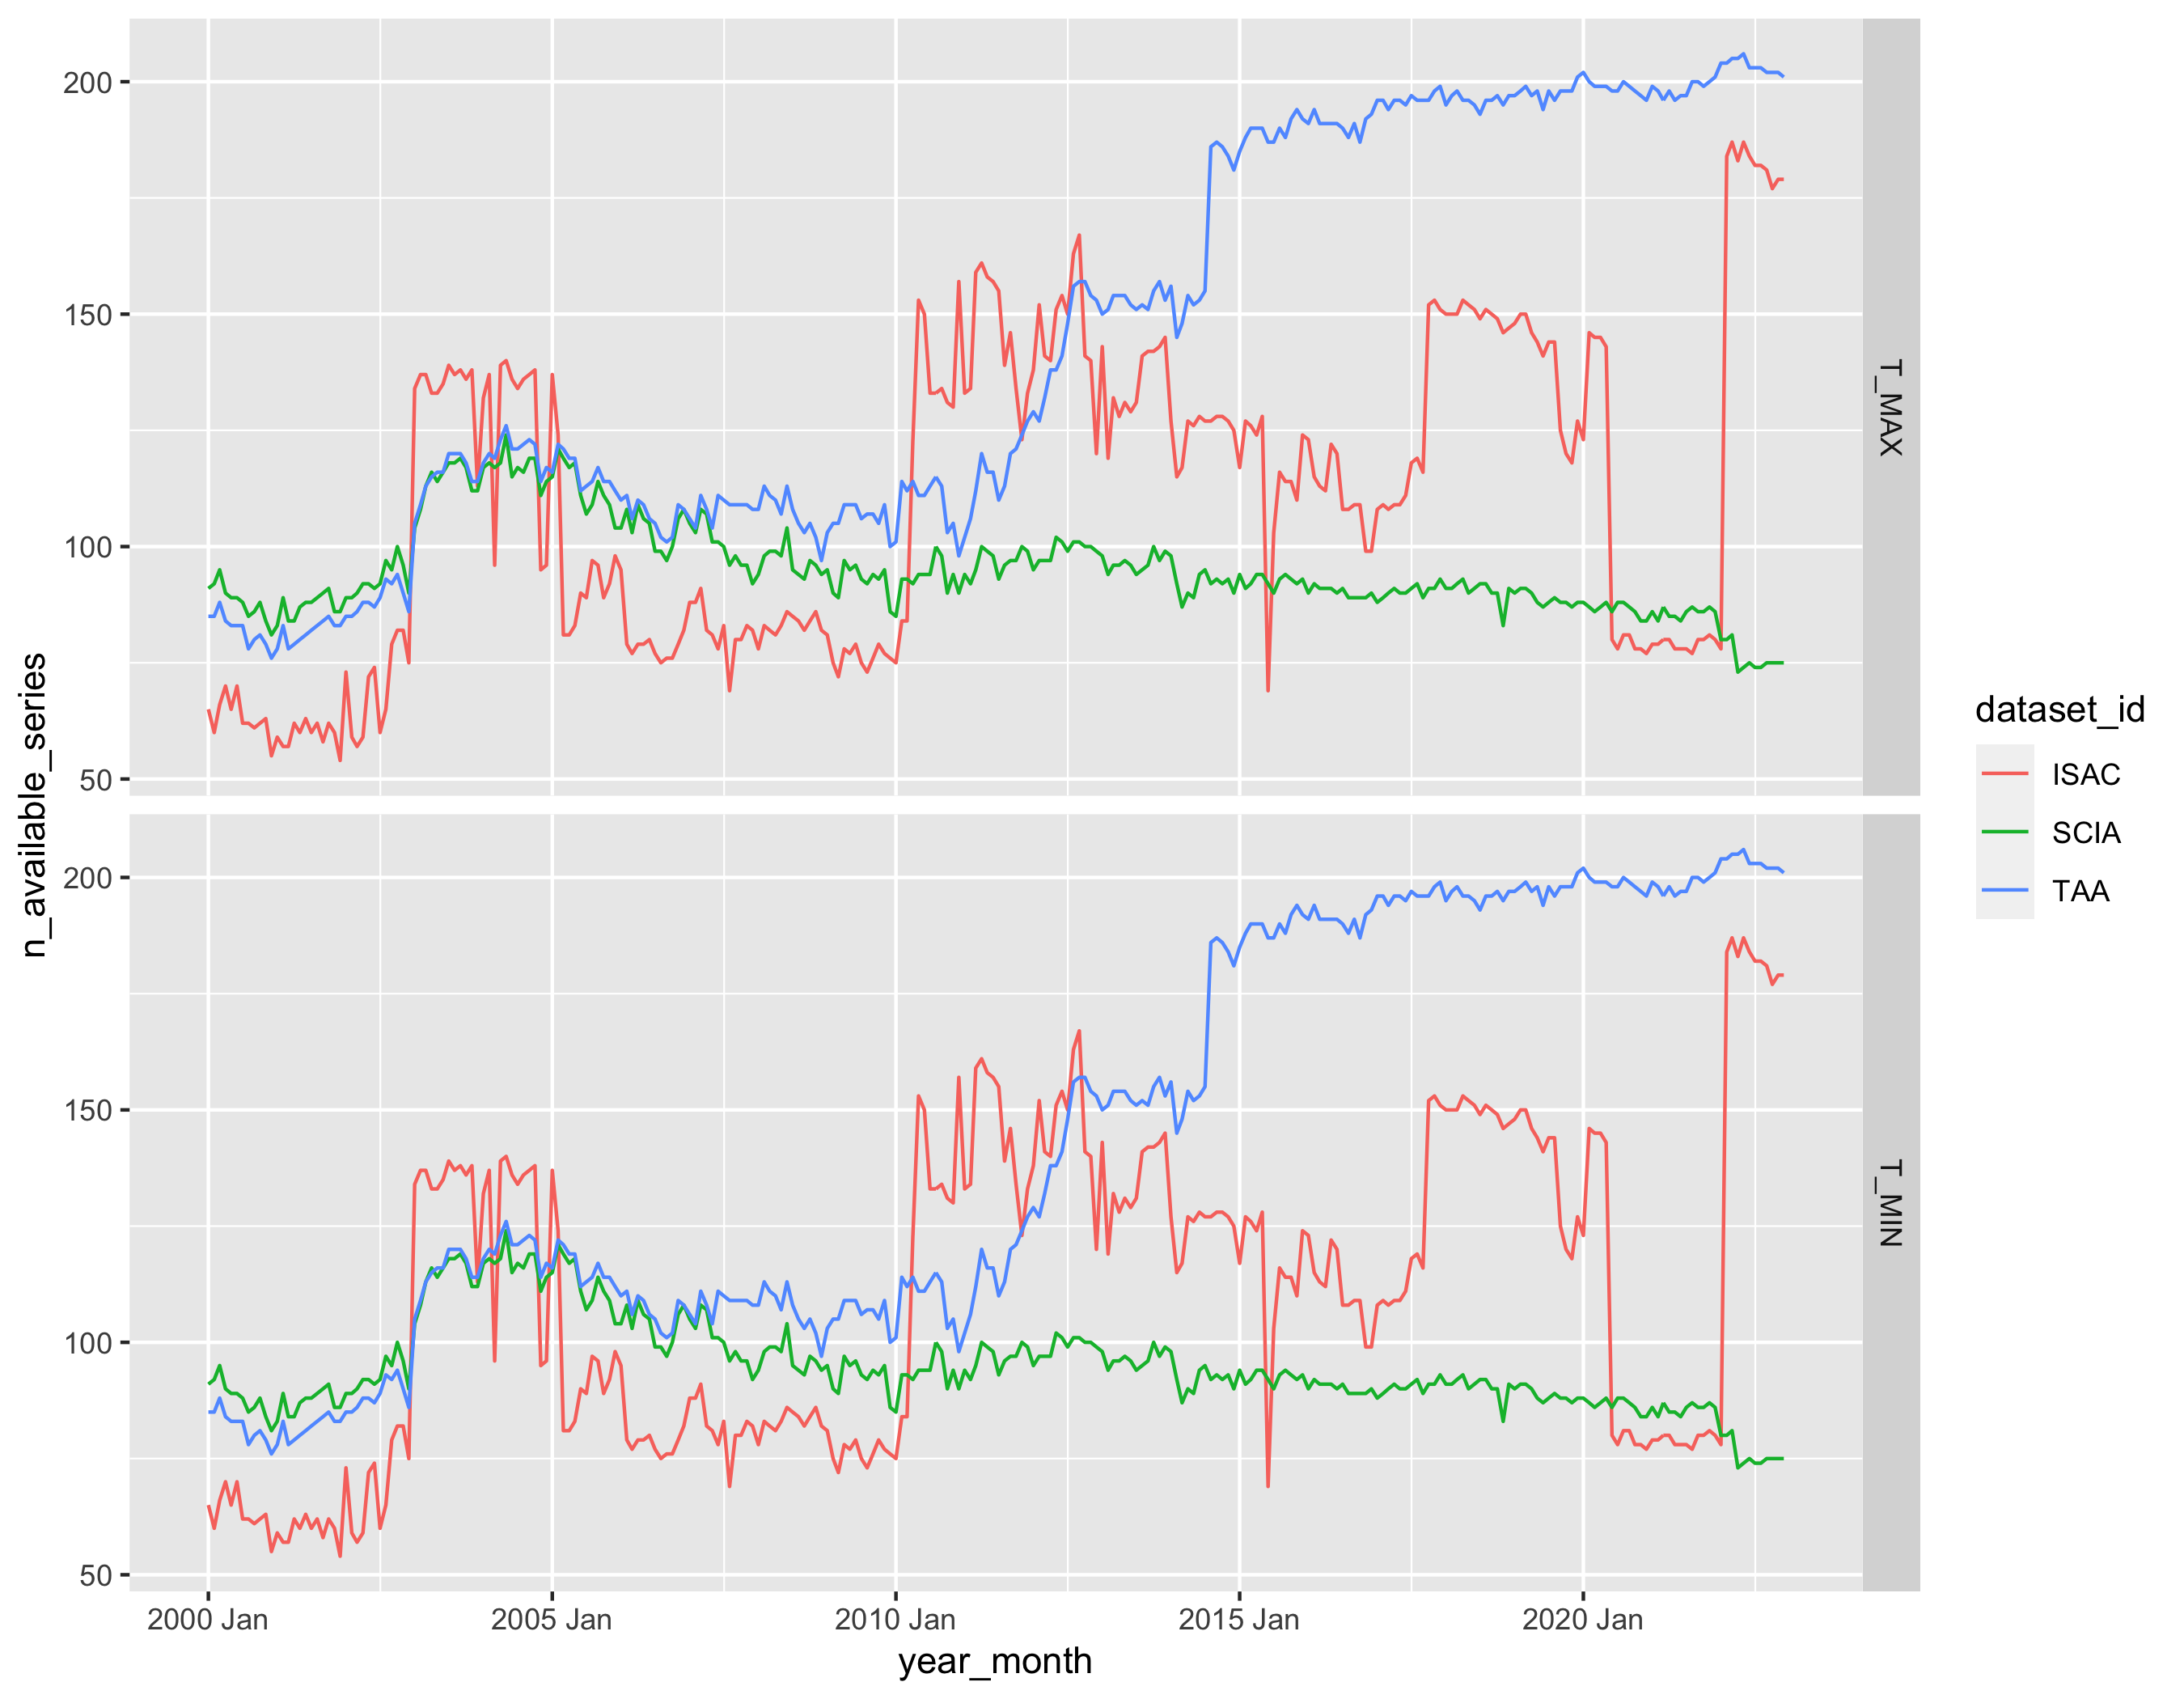

In [20]:
qc_database <- concat_databases(
    open_checkpoint("SCIA", "qc1") |> filter_checkpoint_inside(state_boundaries),
    open_checkpoint("TAA", "qc1") |> filter_checkpoint_inside(state_boundaries),
) |> concat_databases(
        open_checkpoint("ISAC", "qc1") |> filter_checkpoint_inside(state_boundaries),
)
c(p, ymonthly_avail) %<-% ymonthly_availabilities(qc_database,
    against = NULL,
    start_date = first_date,
    end_date = last_date
)
p


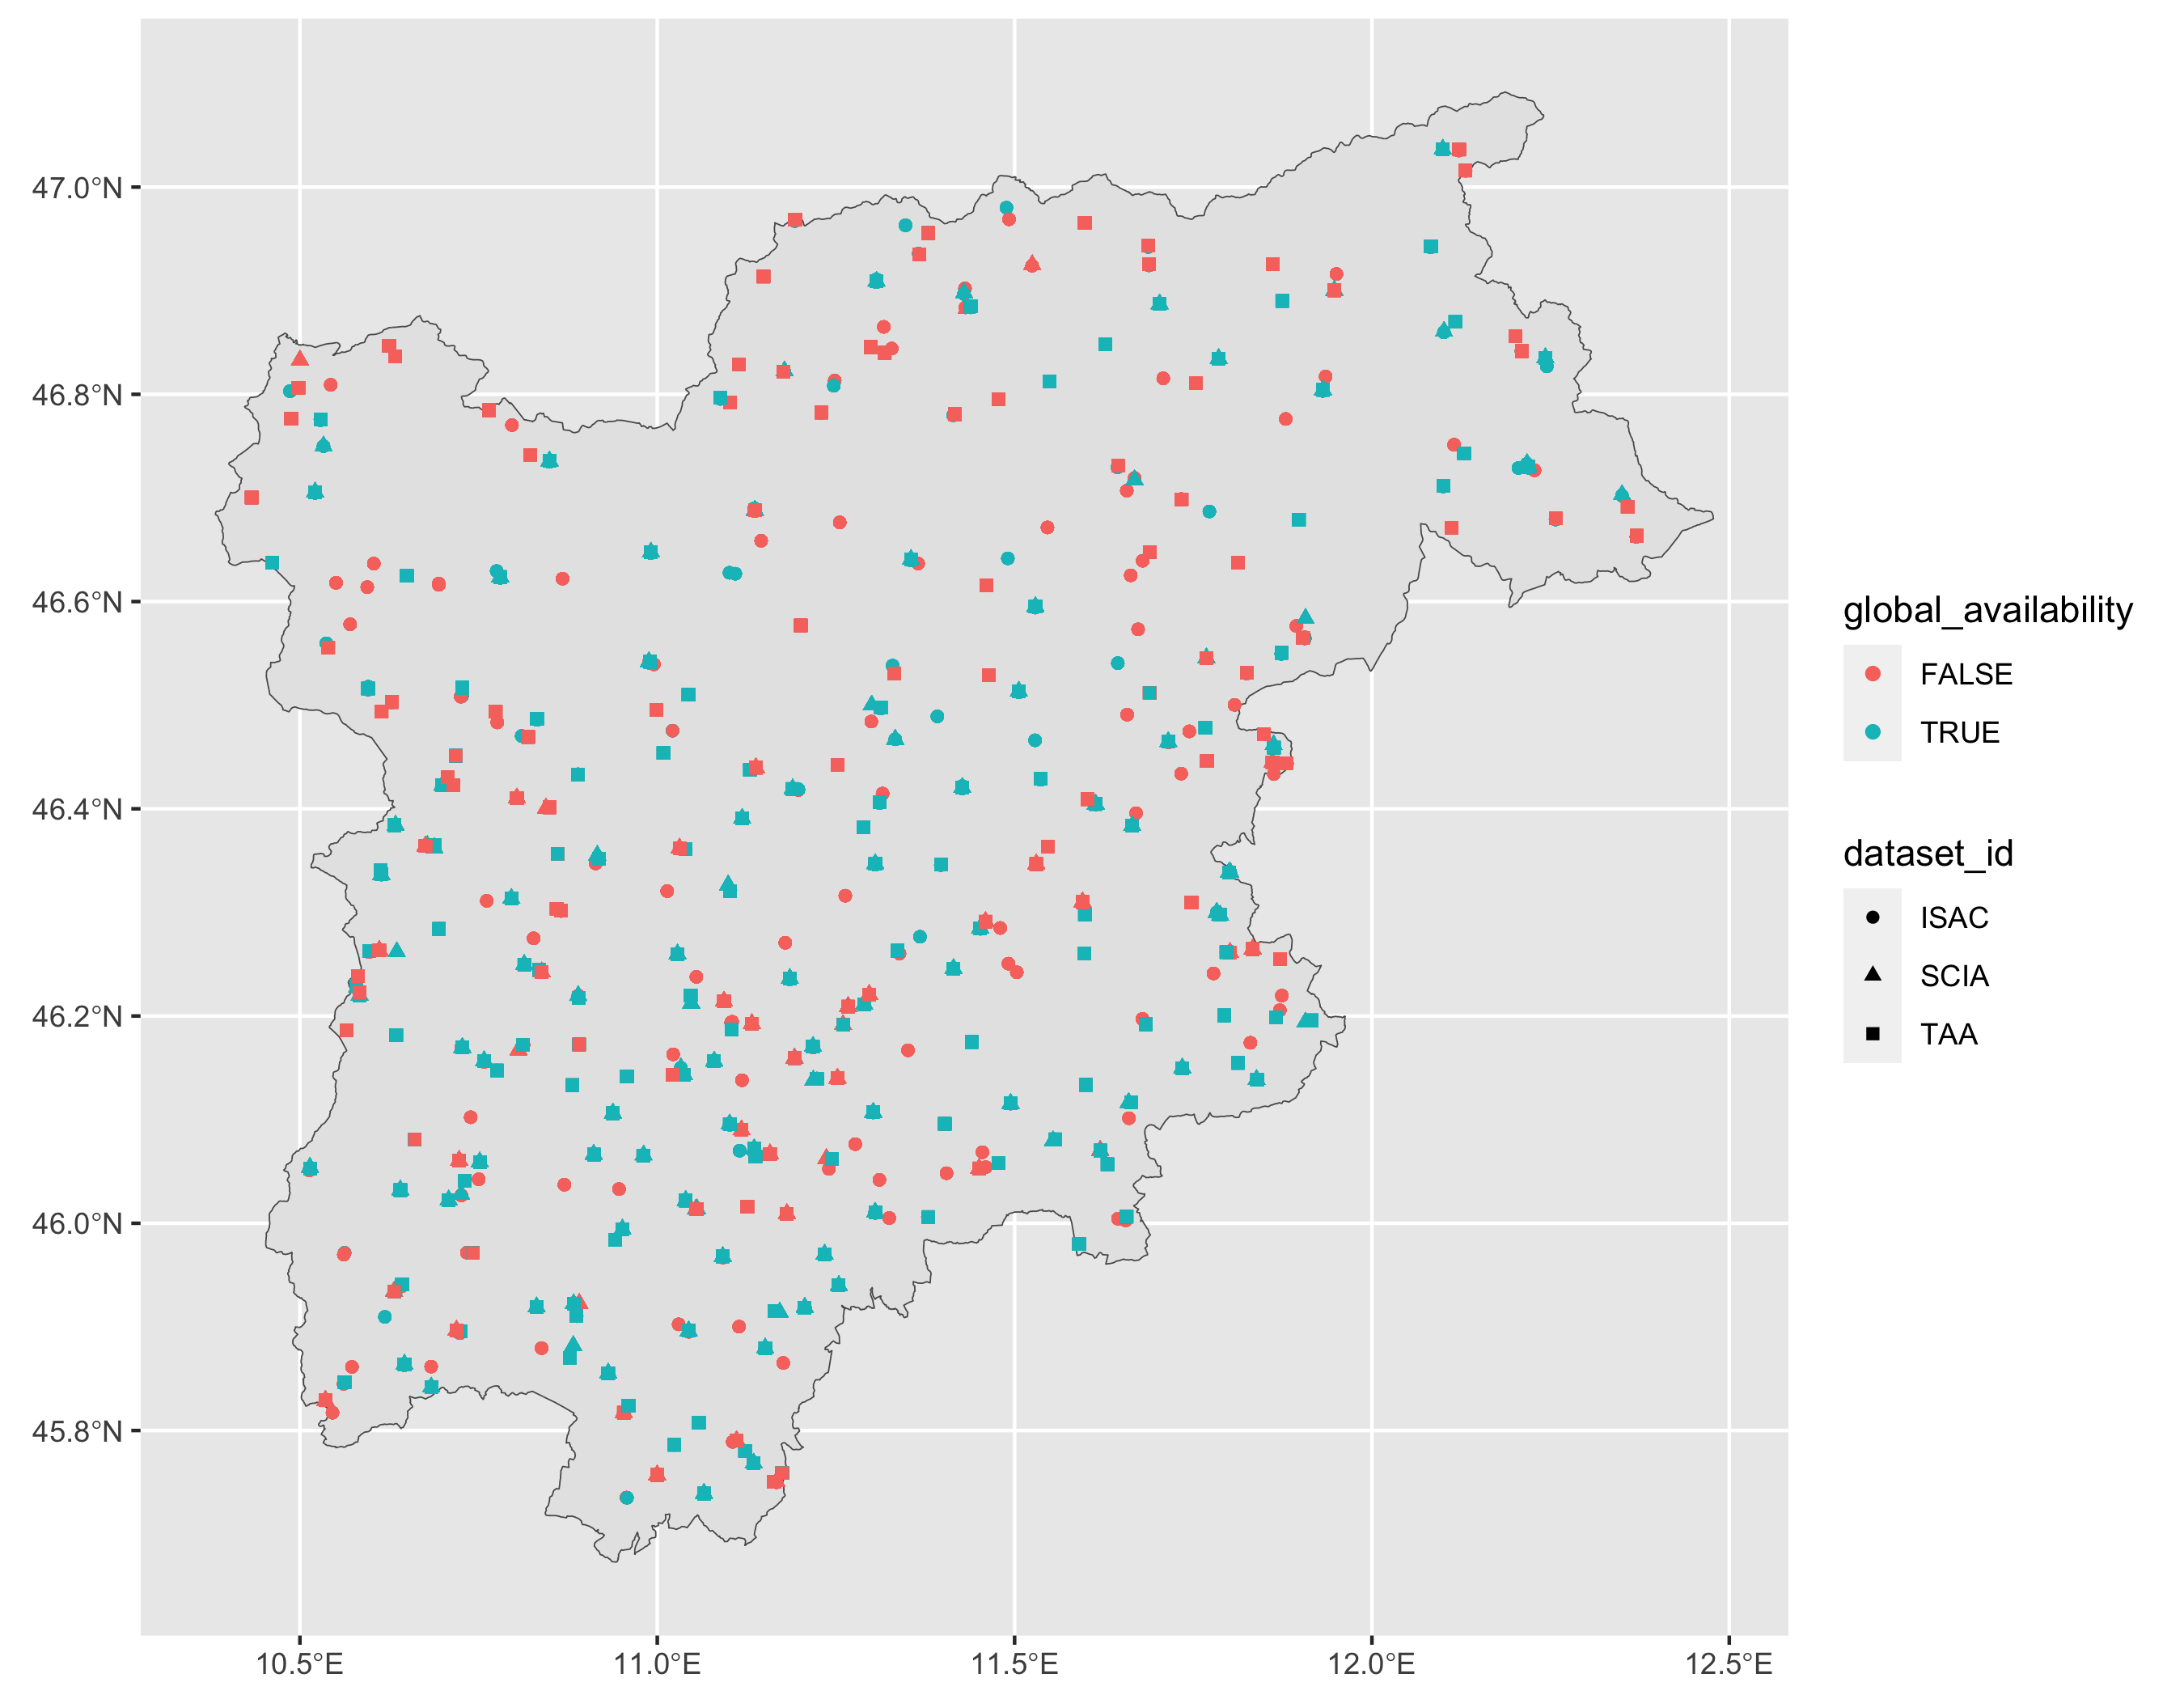

In [21]:
c(p, climats) %<-% spatial_availabilities(ymonthly_avail, qc_database$meta, state_boundaries)
p


In [23]:
rm(qc_database)
rm(ymonthly_avail)
rm(climats)
rm(p)
gc()


Warning message in rm(qc_database):
"oggetto 'qc_database' non trovato"
Warning message in rm(ymonthly_avail):
"oggetto 'ymonthly_avail' non trovato"
Warning message in rm(climats):
"oggetto 'climats' non trovato"
Warning message in rm(p):
"oggetto 'p' non trovato"


,used,(Mb),gc trigger,(Mb),limit (Mb),max used,(Mb)
Ncells,2304865,123.1,6712642,358.5,NA,16385611,875.1
Vcells,6414018,49.0,218583648,1667.7,16384,341536950,2605.8


## Merging
Gap-filling con altri dataset

### Match stazioni
Partendo dal file di analisi appena scritto preparo dei filtri che categorizzino il match.

Le possibilità sono:
- `tag_same_station`: il match indica una stessa stazione;
- `tag_unusable`: il match è inutilizzabile;
- `tag_pairable`: il match indica che le stazioni sono utilizzabili per fare gap-filling.

Può essere che un match sia sulla stessa stazione ma che sia inutilizzabile; `tag_unusable` e `tag_pairable` invece si dovrebbero escludere vicendevolmente.

In [ ]:
qc_state <- open_checkpoint(dataset_id, "qc1")
qc_scia <- open_checkpoint("SCIA", "qc1") |> filter_checkpoint_inside(state_boundaries)
analysis_results <- perform_analysis(
    qc_state,
    qc_scia,
    dist_km = , # 10,
    first_date,
    last_date,
    str_to_lower(state),
)

rm(qc_state)
rm(qc_scia)
gc()


In [ ]:
analysis_results <- tag_analysis(analysis_results, list("same_station" = tag_same_station, "unusable" = tag_unusable))
analysis_results$analysis |>
        group_by(same_station, unusable) |>
        tally()
filter(analysis_results$analysis, same_station) |>
        group_by(station_id.x) |>
        tally() |>
        filter(n != 2L & n != 4L)
filter(analysis_results$analysis, same_station) |>
        group_by(station_id.y) |>
        tally() |>
        filter(n != 2L)


In [ ]:
combination_results <- build_combined_database(analysis_results, use_corrections = TRUE, checks = TRUE, test_bounds = 1, match_selectors = NULL)
checkpoint_database(combination_results$database, dataset_id, "scia_merged")
save_match_list(combination_results$match_list, dataset_id, "scia_merged")


In [ ]:
combined_database <- open_checkpoint(dataset_id, "scia_merged")
c(p, ymonthly_avail) %<-% ymonthly_availabilities(combined_database,
    start_date = first_date,
    end_date = last_date
)
p


In [ ]:
c(p, climats) %<-% spatial_availabilities(ymonthly_avail, combined_database$meta, state_boundaries)
p


In [ ]:
rm(ymonthly_avail)
rm(climats)
rm(combination_results)
rm(combined_database)
gc()


### Merge interno

In [ ]:
scia_merged <- open_checkpoint(dataset_id, "scia_merged")
analysis_results <- perform_analysis_symmetric(
    scia_merged,
    dist_km = 6,
    first_date,
    last_date,
    file.path("vda", "internal.xlsx"),
    default_symmetric_filter,
    priority_table = NULL,
)

rm(scia_merged)
gc()


In [ ]:
analysis_results <- tag_analysis(analysis_results, list("same_station" = tag_same_station_internal, "unusable" = tag_unusable_internal))
analysis_results$analysis |>
        group_by(same_station, unusable) |>
        tally()
filter(analysis_results$analysis, same_station) |>
        group_by(station_id.x) |>
        tally() |>
        filter(n != 2L & n != 4L)
filter(analysis_results$analysis, same_station) |>
        group_by(station_id.y) |>
        tally() |>
        filter(n != 2L)


In [ ]:
combination_results <- build_combined_database(analysis_results, use_corrections = TRUE, checks = TRUE, test_bounds = 1.5, match_selectors = NULL)
checkpoint_database(combination_results$database, dataset_id, "merged")
save_match_list(combination_results$match_list, dataset_id, "merged")
rm(combination_results)
gc()


In [ ]:
combined_database <- open_checkpoint(dataset_id, "merged")
c(p, ymonthly_avail) %<-% ymonthly_availabilities(combined_database,
    start_date = first_date,
    end_date = last_date
)
p


In [ ]:
c(p, climats) %<-% spatial_availabilities(ymonthly_avail, combined_database$meta, state_boundaries)
p


In [ ]:
print("Available series per variable:")
climats |>
    as_tibble() |>
    group_by(variable, station_id) |>
    summarise(usable = all(clim_available), .groups = "drop_last") |>
    filter(usable) |>
    tally()


In [ ]:
rm(ymonthly_avail)
rm(climats)
rm(combined_database)
gc()


In [ ]:
source("notebooks/integrazioni_regionali/procedure/checkpoint.R")
open_checkpoint(dataset_id, "merged")$data |>
    distinct(station_id, variable) |>
    compute() |>
    nrow()


In [ ]:
# Lanciare da terminale
source("src/pairing/displaying.R")
source("notebooks/integrazioni_regionali/procedure/checkpoint.R")
open_checkpoint(, "merged") |>
    launch_leaflet()
